In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader

import numpy as np
from glob import glob
from scipy.io import loadmat
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
from tensorboardX import SummaryWriter

In [3]:
IMG_DIR = 'data/flower_data/images/*'
LBL_DIR = 'data/flower_data/imagelabels.mat'

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 25
num_classes = 102
batch_size = 8
learning_rate = 0.001
num_imgs = 4

# Tensorboard
writer = SummaryWriter()

In [4]:
class Flowers102_Dataset(Dataset):
    def __init__(self, img_dir, lbl_dir, transform=None):
        self.img_glob = sorted(glob(img_dir))
        self.labels = loadmat(LBL_DIR)['labels'].squeeze()
        self.transform = transform
        self.classes = 'hi'
    def __len__(self):
        return len(self.img_glob)
    def __getitem__(self, idx):
        image = Image.open(self.img_glob[idx])
        # Classes must be zero indexed
        label = self.labels[idx]-1
        
        if self.transform:
            image = self.transform(image)
        return (image, label)

data_transform = transforms.Compose([
                 transforms.Resize(256),
                 transforms.CenterCrop(224),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

flower_dataset = Flowers102_Dataset(IMG_DIR, LBL_DIR, data_transform)
train_size = int(0.95*len(flower_dataset))
test_size = len(flower_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(flower_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

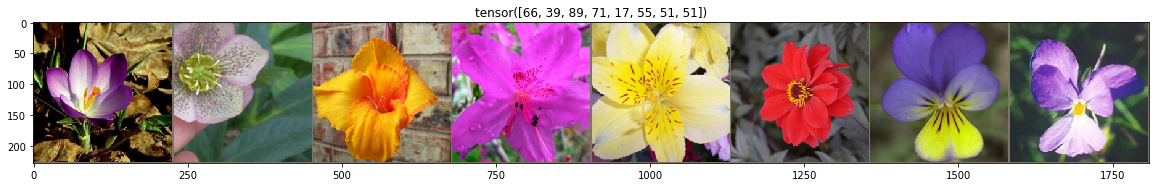

In [ ]:
def unnormalize(inp):
    # Unnormalize image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp
def imshow(inp, title=None):
    """Imshow for Tensor."""
    # Convert from tensor to PIL image
    inp = inp.numpy().transpose((1, 2, 0))
    inp = unnormalize(inp)
    plt.figure(figsize=(20,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
    
# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = vutils.make_grid(inputs)

imshow(out, str(classes))

In [ ]:
# Load Pretrained Network and Freeze Layers except final classifer layers
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [ ]:
# Different Models that can be fine tuned
# 
resnet50 = torchvision.models.resnet50(pretrained=True)
set_parameter_requires_grad(resnet50, True)
resnet50.fc = nn.Linear(2048, num_classes)

squeezenet = torchvision.models.squeezenet1_1(pretrained=True)
set_parameter_requires_grad(squeezenet, True)
squeezenet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

In [ ]:
def tb_fig(tensor_batch, title=None):
    # Make a grid from batch
    out = vutils.make_grid(tensor_batch, )
    # Convert from tensor to PIL image
    inp = out.cpu().numpy().transpose((1, 2, 0))
    inp = unnormalize(inp)
    fig = plt.figure(figsize=(20,10))
    img = fig.add_subplot(1,1,1)
    if title is not None:
        img.set_title(title)
    img.imshow(inp)
    return fig

def train(data_loader, model, criterion, optimizer, epoch, train_step, device):
    model.train()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(data_loader):
        # Move
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Accuracy Measurement
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        acc =  (predicted == labels).sum().item() / labels.size(0)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % 100 == 0:
            fig = tb_fig(images[0:4], str(labels[0:4].cpu().numpy())+'\n'+str(predicted[0:4].cpu().numpy()))
            print (f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(data_loader)}], Loss: {loss.item():.4f}, Acc {acc:.4f}")
            writer.add_scalar('Train/Loss', loss.item(), train_step)
            writer.add_figure('Predictions/Train', fig, train_step)
        train_step +=1
        
    total_acc = correct /total
    writer.add_scalar('Train/Accuracy', total_acc, train_step)
    return train_step

def test(data_loader, model, criterion, test_step, device):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Accuracy Measurement
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            acc =  (predicted == labels).sum().item() / labels.size(0)
            
            if i % 10 == 0:
                fig = tb_fig(images[0:4], str(labels[0:4].cpu().numpy())+'\n'+str(predicted[0:4].cpu().numpy()))
                writer.add_scalar('Test/Loss', loss.item(), test_step)
                writer.add_figure('Predictions/Test', fig, test_step)
            test_step +=1
                
        total_acc = correct /total
        print(f'Test Accuracy of the model on the test images: {total_acc:.4f}')
        writer.add_scalar('Test/Accuracy', total_acc, test_step)
        
        return test_step

### Download Images and Labels from
[Visual Geometrey Group Website](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/)

In [ ]:
# Train and Test Resnet
train_step = 0
test_step = 0
# Choose what model you want to use
model = resnet50
model.to(device)
#
dummy_input = torch.Tensor(1, 3, 224, 224).to(device)
writer.add_graph(model, (dummy_input, ))

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_step = train(train_loader, model, criterion, optimizer, epoch, train_step, device)
    test_step = test(test_loader, model, criterion, test_step, device)

Epoch [1/25], Step [1/973], Loss: 4.4963
Epoch [1/25], Step [101/973], Loss: 3.5946
Epoch [1/25], Step [201/973], Loss: 1.3986
Epoch [1/25], Step [301/973], Loss: 2.6123
Epoch [1/25], Step [401/973], Loss: 2.5458
Epoch [1/25], Step [501/973], Loss: 0.9555
Epoch [1/25], Step [601/973], Loss: 1.2791
Epoch [1/25], Step [701/973], Loss: 0.4048
Epoch [1/25], Step [801/973], Loss: 1.4483
Epoch [1/25], Step [901/973], Loss: 1.1425
Test Accuracy of the model on the test images: 0.8341
Epoch [2/25], Step [1/973], Loss: 0.3552
Epoch [2/25], Step [101/973], Loss: 1.1575
Epoch [2/25], Step [201/973], Loss: 0.5642
Epoch [2/25], Step [301/973], Loss: 0.6378
Epoch [2/25], Step [401/973], Loss: 1.1209
Epoch [2/25], Step [501/973], Loss: 0.3735
Epoch [2/25], Step [601/973], Loss: 0.4714
Epoch [2/25], Step [701/973], Loss: 0.5813
Epoch [2/25], Step [801/973], Loss: 0.4196
Epoch [2/25], Step [901/973], Loss: 0.9567
Test Accuracy of the model on the test images: 0.8902
Epoch [3/25], Step [1/973], Loss: 1.